# Acoustic data scattering coefficients embedding with UMAP

"We will investigate Uniform Manifold Projection and Approximation (UMAP). PCA and ICA preserve quite well the pair-wise distances of data points at the costs of losing information about the local structure. Because they preserve the distances, the techniques are often used for clustering tasks later on. UMAP basically learns the high-dimensional manifold of the data and maps it into a lower dimensional space. By doing so, it preserves much better the local structure but at the costs of global structures, meaning that distances between distant data points might be distorted. Therefore, more care has to be taken, if we perform clustering in the UMAP space.

In the literature, these UMAP spaces are called atlases, since they resemble a map of the data such as the activation atlas of a convolutional neural network presented in Cartler et al. 2019. Therefore, we decided to call the UMAP spaces of a continuous seismogram a "seismogram atlas". Seismogram atlases were introduced in Steinmann et al. 2023."

## Load data and libraries

In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import umap.umap_ as umap
from sklearn.metrics import pairwise_distances
import xarray as xr
from cmcrameri import cm

import loader
import loader_2
%config InlineBackend.figure_format = "svg"
color_style = cm.vikO # selecting a cyclic color style for the plots

%matplotlib widget

Loading model and data
Done !
Loading model and data
Done !


## Trace stream

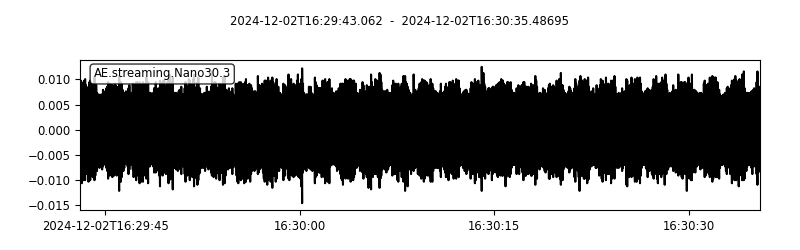

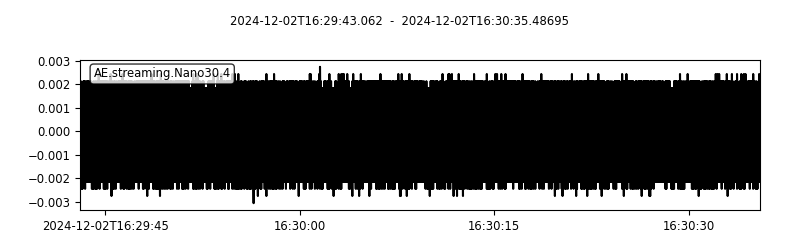

Streams loaded


In [2]:
loader.stream.plot()
loader_2.stream.plot()
print("Streams loaded")

## Load, normalize and stack scattering coefficients

In [3]:
filepath_scatterings = loader.scattering_coef_path + "Scat_coef_" + loader.pooling + "_" + loader.data_file

# Load scatterings
print("Loading "+filepath_scatterings)
data_scatterings, _ = pickle.load(open(filepath_scatterings, "rb"))

# Get sampling rate
sampling_rate = loader.stream[0].stats.sampling_rate
print(f"Sampling rate: {sampling_rate / 1e6} MHz")

# Extract scattering coefficients
scattering_coefficients = loader.reshape_scatterings(data_scatterings)

# Work on a copy
scatterings_normalized = scattering_coefficients.copy()

# Get the scattering coefficients (log)
scatterings_normalized = np.log(scatterings_normalized + 1e-100)

# Normalize
scatterings_normalized.order_2.data -= scatterings_normalized.order_1.data[:, :, :, None]
scatterings_normalized.order_1.data /= scatterings_normalized.order_1.data.std()
scatterings_normalized.order_1.data -= scatterings_normalized.order_1.data.min()
scatterings_normalized.order_2.data /= scatterings_normalized.order_2.data.std() 
scatterings_normalized.order_2.data -= scatterings_normalized.order_2.data.min()

# Mask Nyquist frequencies
# scatterings_normalized.order_2.data = scatterings_normalized.order_2.where(scatterings_normalized.f1 >= scatterings_normalized.f2, 0)
# Reduce order 1 which is duplicated
# scatterings_normalized["order_1"] = scatterings_normalized.order_1.mean(dim="f2")

# Keep non na
print(f"Time samples before NaN droppping: {len(scatterings_normalized.time)}")
scatterings_normalized = scatterings_normalized.dropna(dim="time", how="any")
print(f"Time samples after NaN droppping: {len(scatterings_normalized.time)}")


def design_matrix(ds, standardize=True):
    """Design matrix of scattering coefficients."""
    n = ds.time.shape[0]
    x1 = ds.order_1.data.reshape(n, -1)
    x2 = ds.order_2.data.reshape(n, -1)
    x = np.hstack((x1, x2))
    if standardize is True:
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
    return x

# Design matrix
t_1 = scatterings_normalized.time - scatterings_normalized.time[0]
x_1 = design_matrix(scatterings_normalized, standardize=True)
print(f"Extracted design matrix of shape: {x_1.shape}")

Loading Scattering_coefficients/Scat_coef_med_Stream_7075_APT_0.1_1_E_ch3_0-100.pkl
Sampling rate: 2.0 MHz
Time samples before NaN droppping: 2621
Time samples after NaN droppping: 2621
Extracted design matrix of shape: (2621, 280)


In [4]:
filepath_scatterings_2 = loader_2.scattering_coef_path + "Scat_coef_" + loader_2.pooling + "_" + loader_2.data_file 

# Load scatterings
print("Loading "+filepath_scatterings_2)
data_scatterings, _ = pickle.load(open(filepath_scatterings_2, "rb"))

# Get sampling rate
sampling_rate = loader_2.stream[0].stats.sampling_rate
print(f"Sampling rate: {sampling_rate / 1e6} MHz")

# Extract scattering coefficients
scattering_coefficients = loader_2.reshape_scatterings(data_scatterings)

# Work on a copy
scatterings_normalized = scattering_coefficients.copy()

# Get the scattering coefficients (log)
scatterings_normalized = np.log(scatterings_normalized + 1e-100)

# Normalize
scatterings_normalized.order_2.data -= scatterings_normalized.order_1.data[:, :, :, None]
scatterings_normalized.order_1.data /= scatterings_normalized.order_1.data.std()
scatterings_normalized.order_1.data -= scatterings_normalized.order_1.data.min()
scatterings_normalized.order_2.data /= scatterings_normalized.order_2.data.std() 
scatterings_normalized.order_2.data -= scatterings_normalized.order_2.data.min()

# Mask Nyquist frequencies
# scatterings_normalized.order_2.data = scatterings_normalized.order_2.where(scatterings_normalized.f1 >= scatterings_normalized.f2, 0)
# Reduce order 1 which is duplicated
# scatterings_normalized["order_1"] = scatterings_normalized.order_1.mean(dim="f2")

# Keep non na
print(f"Time samples before NaN droppping: {len(scatterings_normalized.time)}")
scatterings_normalized = scatterings_normalized.dropna(dim="time", how="any")
print(f"Time samples after NaN droppping: {len(scatterings_normalized.time)}")


def design_matrix(ds, standardize=True):
    """Design matrix of scattering coefficients."""
    n = ds.time.shape[0]
    x1 = ds.order_1.data.reshape(n, -1)
    x2 = ds.order_2.data.reshape(n, -1)
    x = np.hstack((x1, x2))
    if standardize is True:
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
    return x

# Design matrix
t_2 = scatterings_normalized.time - scatterings_normalized.time[0]
x_2 = design_matrix(scatterings_normalized, standardize=True)
print(f"Extracted design matrix of shape: {x_2.shape}")

Loading Scattering_coefficients/Scat_coef_med_Stream_7075_APT_0.1_1_E_ch4_0-100.pkl
Sampling rate: 2.0 MHz
Time samples before NaN droppping: 2621
Time samples after NaN droppping: 2621
Extracted design matrix of shape: (2621, 280)


### Scatterings coefficients combination

In [5]:
# Concatenate the two design matrices
x = np.concatenate((x_1, x_2), axis=0)
print(f"Concatenated design matrix of shape: {x.shape}")

# Concatenate the two time vectors
t = np.concatenate((t_1, t_2+t_1[-1]), axis=0)
print(f"Concatenated time vector of shape: {t.shape}")
# show limits of the time vector
print(f"Time vector limits: {t[0]:.2f} - {t[-1]:.2f}")


Concatenated design matrix of shape: (5242, 280)
Concatenated time vector of shape: (5242,)
Time vector limits: 0.00 - 104.80


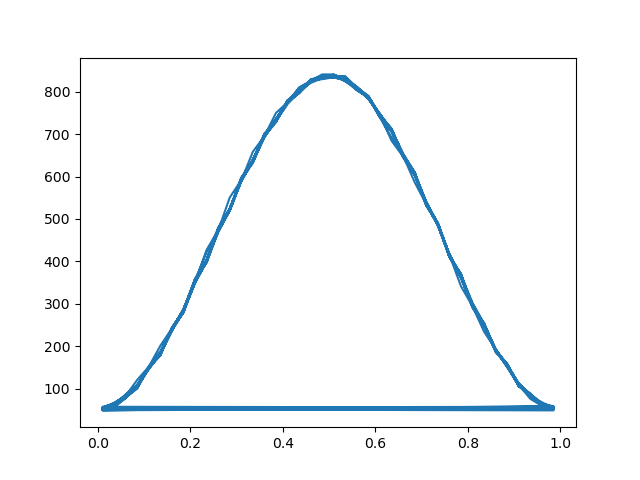

In [6]:
# Load and resample parametric data
Param_1 = pickle.load(open(loader.param_path, "rb"))

Param_1.norm_cy += 0.21
Param_1.loc[Param_1.norm_cy>1,"norm_cy"] -= 1

plt.figure()
plt.plot(Param_1.norm_cy,Param_1.PARA1)
plt.show()

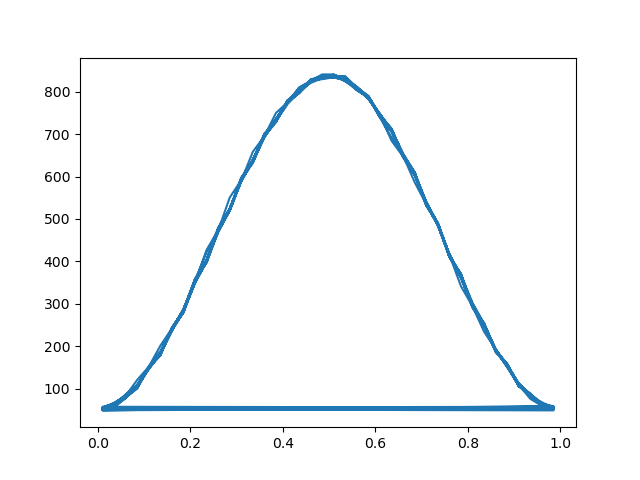

In [7]:
# Load and resample parametric data
Param_2 = pickle.load(open(loader_2.param_path, "rb"))

Param_2.norm_cy += 0.21
Param_2.loc[Param_2.norm_cy>1,"norm_cy"] -= 1

plt.figure()
plt.plot(Param_2.norm_cy,Param_2.PARA1)
plt.show()

Concatenated parametric data of shape: (2096, 9)
Parametric data limits: 0.14 - 0.31


/tmp/ipykernel_23940/169332445.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Param_2.time = Param_2.time - Param_2.time[0] + Param_1.time[-1]


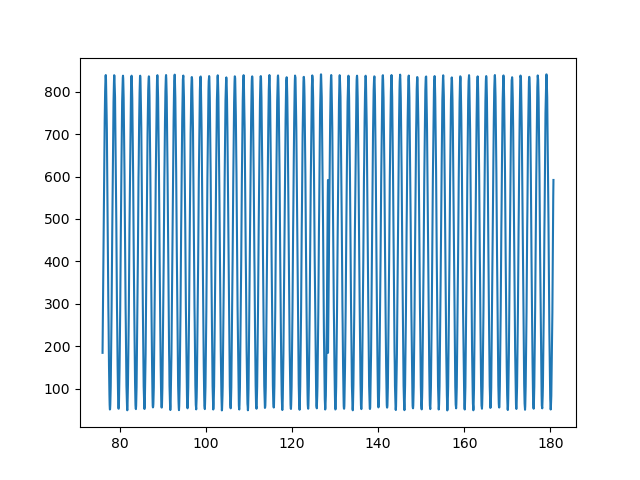

In [8]:
Param_2.time = Param_2.time - Param_2.time[0] + Param_1.time[-1]

# Concatenate the two Param dataframes
Param = pd.concat([Param_1, Param_2], axis=0)
print(f"Concatenated parametric data of shape: {Param.shape}")
# show limits of the time vector
print(f"Parametric data limits: {Param.norm_cy.iloc[0]:.2f} - {Param.norm_cy.iloc[-1]:.2f}")

plt.figure()
plt.plot(Param.time,Param.PARA1)
plt.show()

# UMAP apply

In [20]:
umap_model = umap.UMAP(n_components=2,random_state=42,n_neighbors=5, min_dist=0, n_jobs=-1)
embedding = umap_model.fit_transform(x)

/home/delaselt/miniconda3/envs/scatnet_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/delaselt/miniconda3/envs/scatnet_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


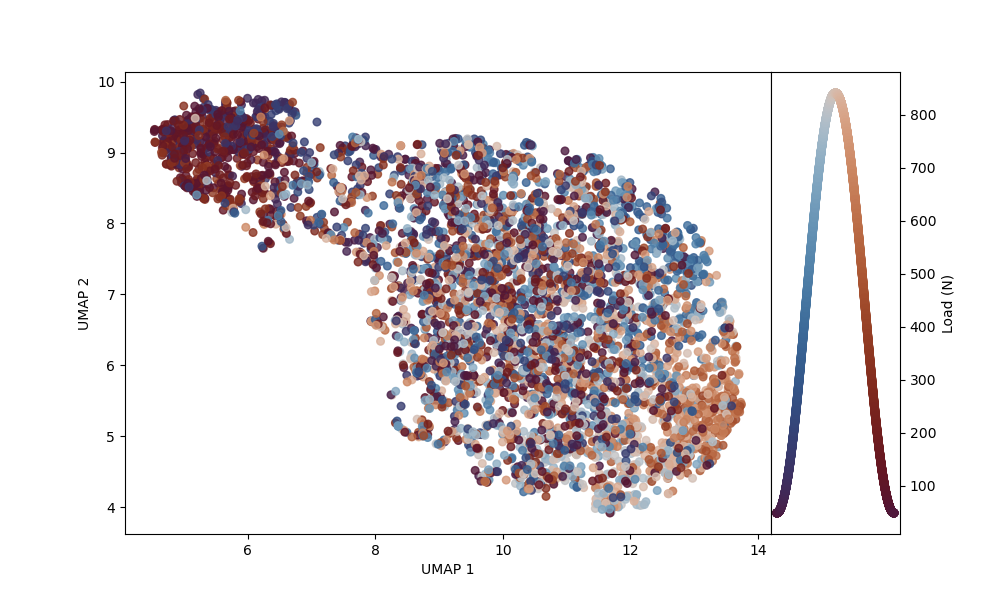

In [21]:
%matplotlib widget
from scipy.interpolate import interp1d

# Defining colors from parametric measures
x_p = Param.norm_cy.values
t_p = (Param.time - Param.time.iloc[0]).values
isna = np.isnan(x_p)
x_p = x_p[~isna]
t_p = t_p[~isna]
interpolator = interp1d(t_p, x_p, bounds_error=False, fill_value=0)
color_i = interpolator(t)

# Visualize the UMAP results
plt.close()
fig, ax = plt.subplots(1,2,figsize=(10, 6),gridspec_kw={'width_ratios': [5, 1]})
im = ax[0].scatter(embedding[:,0],embedding[:,1],c=color_i,s=30, alpha=0.8,cmap=color_style)
ax[0].set_ylabel("UMAP 2")
ax[0].set_xlabel("UMAP 1")

# add a second graph vertically, on the right side, containing a single period of a sinusoidal signal colored with the same colormap
t_sin = np.linspace(0.75, 1.75, len(color_i))

max_load = Param.PARA1.max()
min_load = Param.PARA1.min()
load = (max_load-min_load)/2*np.sin(2 * np.pi * t_sin)+(max_load+min_load)/2
im = ax[1].scatter(t_sin, load, c=t_sin, cmap=color_style, s=30,alpha=0.7) 
ax[1].set_ylabel("Load (N)")

# place y ticks on the right
ax[1].yaxis.tick_right()
# move the y-axis label to the right
ax[1].yaxis.set_label_position("right")
ax[1].set_xticks([])
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)  # Adjust the width space between subplots

plt.show()

In [22]:
# save the figure in pdf format including the name the umap parameters, the channel and the pooling. The file will be saved in the directory precised in the loader.py file
save_path = loader.fig_path+"umap-"+str(umap_model.n_neighbors)+"-"+str(umap_model.min_dist)+"_"+loader.data_file[7:-4]+"_"+loader.pooling+".pdf"
fig.savefig(save_path,bbox_inches='tight')

## Atlas UMAP with RMS

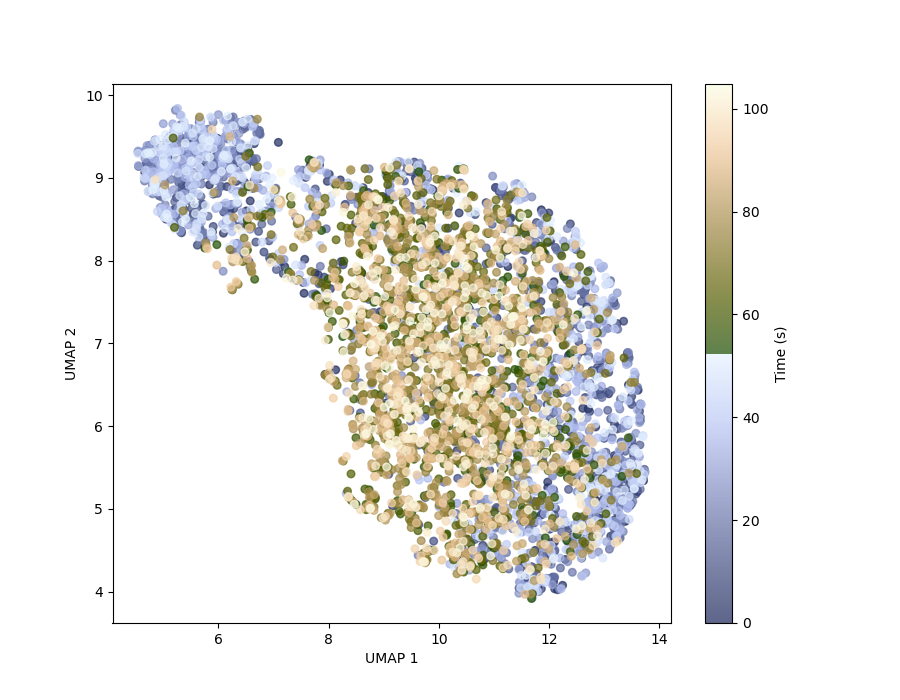

In [23]:
# Defining colors from parametric measures

# saturate values of ABS-ENERGY
x_p = Param_1["ABS-ENERGY"].clip(0, 0.5).values
# x_p = Param_1["ABS-ENERGY"].values
t_p = (Param_1.time - Param_1.time.iloc[0]).values
isna = np.isnan(x_p)
x_p = x_p[~isna]
t_p = t_p[~isna]
interpolator = interp1d(t_p, x_p, bounds_error=False, fill_value=0)
color_i = interpolator(t)

# If timestamps if used
color_i = t

# Visualize the UMAP results
plt.close()
fig2= plt.figure(figsize=(9, 7))
im = plt.scatter(embedding[:,0],embedding[:,1],c=color_i,s=30, alpha=0.7, cmap=cm.oleron)
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

# add colorbar
cbar = plt.colorbar(im)
# cbar.set_label("Absolute energy (attoJ)")
cbar.set_label("Time (s)")

plt.show()

In [24]:
# save the figure in pdf format including the name the umap parameters, the channel and the pooling. The file will be saved in the directory precised in the loader.py file
save_path = loader.fig_path+"CH_umap-"+str(umap_model.n_neighbors)+"-"+str(umap_model.min_dist)+"_"+loader.data_file[7:-4]+"_"+loader.pooling+".pdf"
fig2.savefig(save_path,bbox_inches='tight')

## Explorateur UMAP

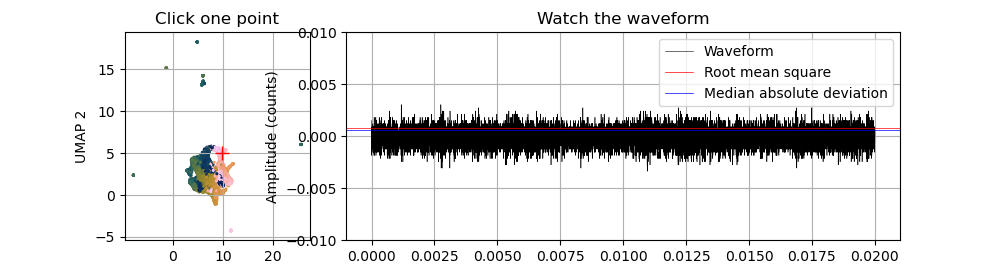

IndexError: list index out of range

In [56]:
# import waveforms

# Get atlas and 2-D PCA
# atlas_coordinates = atlas.load()
# times = scattering_coefficients.load().time
umap_df = pd.DataFrame(
    embedding, 
    columns=["UMAP1", "UMAP2"],
    index=t
)

import obspy
umap_df.index = [obspy.UTCDateTime(time) for time in umap_df.index]

index = 0

y_limits = -0.01, 0.01
plt.close("all")

# Load the first waveform
# start = umap_df.index[index]
# end = stream.segment_duration
# trace = waveforms.read(start, processing=config.waveforms["processing"])[0]
trace = loader.segments[index]
trace_times = np.arange(len(trace)) / sampling_rate

# Initialize the figure
fig, ax = plt.subplots(
    ncols=2,
    gridspec_kw={"width_ratios": [1, 3], "wspace": 0.1},
    figsize=(10, 2.7),
    # constrained_layout=True,
)

# Plot the UMAP
scatter = ax[0].scatter(umap_df.UMAP1.values, umap_df.UMAP2.values, s=5, c=color_i, lw=0, cmap=cm.batlow)
(highlight,) = ax[0].plot(
    umap_df.UMAP1.iloc[index], umap_df.UMAP2.iloc[index], "r+", lw=0.5, ms=10
)
ax[0].set_xlabel("UMAP 1")
ax[0].set_ylabel("UMAP 2")
ax[0].grid()
ax[0].set_title("Click one point")

# Plot the time series
(series,) = ax[1].plot(trace_times, trace, "k", rasterized=True, lw=0.4)
energy = ax[1].axhline(np.sqrt(np.mean(trace**2)), color="r", lw=0.5)
median = ax[1].axhline(np.sqrt(np.median(trace**2)), color="b", lw=0.5)
ax[1].set_ylim(*y_limits)
ax[1].set_ylabel("Amplitude (counts)")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_title("Watch the waveform")
ax[1].grid()
ax[1].legend(
    ["Waveform", "Root mean square", "Median absolute deviation"],
    loc="upper right",
)


def on_click(event):
    if event.inaxes == ax[0]:
        # Find the nearest point
        distances = np.sqrt(
            (umap_df.UMAP1 - event.xdata) ** 2 + (umap_df.UMAP2 - event.ydata) ** 2
        )
        nearest_index = np.argmin(distances)

        # Update the highlighted point
        highlight.set_data(
            [umap_df.UMAP1.iloc[nearest_index]], [umap_df.UMAP2.iloc[nearest_index]]
        )

        # Update the time series
        # nearest_time = waveforms.UTCDateTime(str(umap_df.index[nearest_index]))
        # trace = waveforms.read(
        #     nearest_time, processing=config.waveforms["processing"]
        # )[0]
        trace = loader.segments[nearest_index]

        series.set_data(trace_times, trace)
        energy.set_ydata([np.sqrt(np.mean(trace**2))])
        median.set_ydata([np.sqrt(np.median(trace**2))])

        fig.canvas.draw_idle()


fig.canvas.mpl_connect("button_press_event", on_click)

plt.show()